# Bayesian methods for hackers
![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Scipy
from scipy import stats

# Probabilistic programming
import tensorflow as tf
import edward as ed
from edward.models import Bernoulli,Beta,Empirical,Normal,Poisson,Uniform,Exponential
import pyro

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.color'] = "#d4d4d4"
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['lines.linewidth'] = 2

In [3]:
colors = ['#348ABD']

***
# Introduction

## Introduction

### Scipy and numpy for probabilities and statistics

##### Random Variables sampled from Bernoulli distribution

In [12]:
stats.bernoulli.rvs(0.5, size=10)

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1])

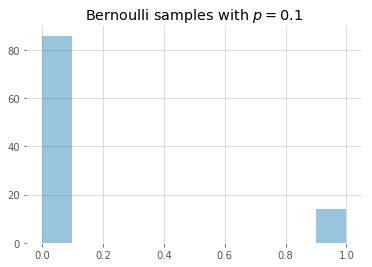

In [57]:
plt.title("Bernoulli samples with $p=0.1$")
plt.hist(stats.bernoulli.rvs(0.1, size=100),color = colors[0],alpha = 0.5)
plt.show()

##### Observing Bernoulli samples with a conjugate Beta prior

In [4]:
def coin_toss(size = 10,p = 0.5):
    data = stats.bernoulli.rvs(p, size=size)
    x = np.linspace(0, 1, 100)
    heads = np.sum(data)
    tails = size - heads
    print("{} heads and {} tails for {} throws".format(heads,tails,size))
    y = stats.beta.pdf(x,1+heads,1+tails)
    plt.title("{} throws, $p={}$".format(size,p))
    plt.plot(x,y,color=colors[0])
    plt.fill_between(x, 0, y, color=colors[0], alpha=0.4)
    plt.vlines(p, 0, np.max(y), color="k", linestyles="--", lw=1)
    plt.show()

7 heads and 3 tails for 10 throws


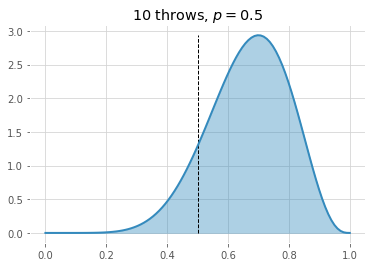

In [53]:
coin_toss()

60 heads and 40 tails for 100 throws


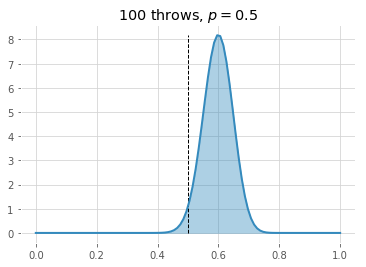

In [54]:
coin_toss(size = 100)

527 heads and 473 tails for 1000 throws


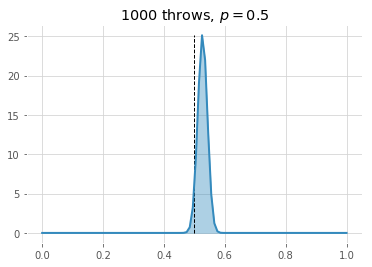

In [55]:
coin_toss(size = 1000)

1 heads and 9 tails for 10 throws


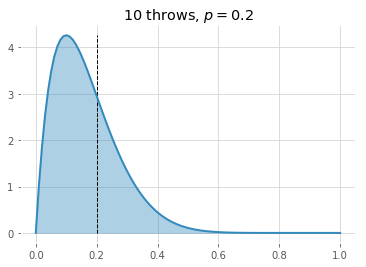

In [56]:
coin_toss(size = 10,p = 0.2)

## Distributions

### Poisson distribution
https://en.wikipedia.org/wiki/Poisson_distribution
> **Discrete probability distribution** that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event. The Poisson distribution can also be used for the number of events in other specified intervals such as distance, area or volume.

$$P(Z = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots $$

### Exponential distribution
$$f_Z(z | \lambda) = \lambda e^{-\lambda z }, \;\; z\ge 0$$

***
# The Bayesian coin toss

## Using Edward

### With Metropolis Hastings
https://github.com/blei-lab/edward/blob/master/examples/beta_bernoulli.py

In [8]:
p_heads = 0.2
size = 50

x_data = stats.bernoulli.rvs(p_heads,size =  size)
n_heads,n_tails = (x_data == 1).sum(),(x_data == 0).sum()
print(n_heads,n_tails)
x_data

7 43


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0])

In [9]:
# MODEL
p = Beta(1.0, 1.0)
x = Bernoulli(probs=p, sample_shape=size)

# INFERENCE
qp = Empirical(params=tf.Variable(tf.zeros([10000]) + 0.5))

proposal_p = Beta(np.float32(1),np.float32(1))

In [10]:
inference = ed.MetropolisHastings({p: qp}, {p: proposal_p}, data={x: x_data})

In [11]:
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 19s | Acceptance Rate: 0.153


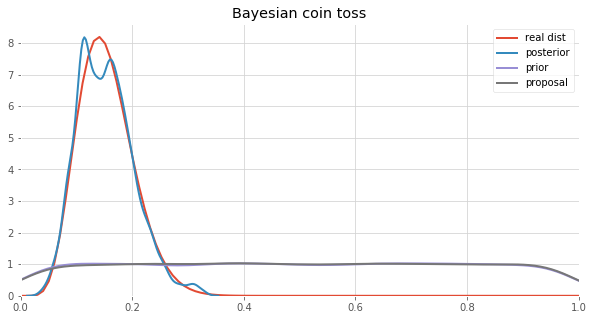

In [14]:
plt.figure(figsize = (10,5))
real_dist = stats.beta.pdf(np.linspace(0,1,100),1+n_heads,1+n_tails)
plt.plot(np.linspace(0,1,100),real_dist,label = "real dist")
sns.distplot(qp.sample(10000).eval(),label = "posterior",hist = False)
sns.distplot(p.sample(10000).eval(),label = "prior",hist = False)
sns.distplot(proposal_p.sample(10000).eval(),label = "proposal",hist = False)
plt.legend()
plt.title("Bayesian coin toss")
plt.xlim(0,1)
plt.show()

### With Variational Inference

In [15]:
x_data = stats.bernoulli.rvs(0.3,size =  100)
x_data

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0])

In [16]:
p = Uniform(low = 0.0,high = 1.0)
x = Bernoulli(probs = p,sample_shape = 10)

In [7]:
qp = Beta(1.0,1.0)

In [18]:
inference = ed.KLqp({p : qp}, data={x:x_data})

In [ ]:
inference.run(n_samples = 10,n_iter = 500)

In [ ]:
from tqdm import tqdm

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in tqdm(range(inference.n_iter)):
    info_dict = inference.update()
    learning_curve.append(info_dict['loss'])
plt.semilogy(learning_curve)
plt.show()

### With Monte Carlo Sampling

##### Creating a function

In [12]:
def bayesian_coin_toss_mcmc(size = 100,
                            p_heads = 0.2,
                            prior = Uniform(low = 0.0,high = 1.0),
                            n_samples = 10000,
                            ):
    
    # DEFINING THE DATA
    x_data = stats.bernoulli.rvs(p_heads,size =  size)
    n_heads,n_tails = (x_data == 1).sum(),(x_data == 0).sum()
    print(">> {} throws with p={} : {} heads and {} tails".format(size,p_heads,n_heads,n_tails))
    
    # DEFINING THE PRIOR
    p = prior
    x = Bernoulli(probs = p,sample_shape = size)
    
    # PREPARING THE POSTERIOR
    qp = Empirical(params=tf.Variable(tf.zeros([n_samples,])+0.5))
    
    # INFERENCE
    inference = ed.HMC(latent_vars = {p : qp}, data={x:x_data})
    inference.initialize(step_size = 1/size)
    
    # RUNNING THE INFERENCE
    sess = ed.get_session()
    init = tf.global_variables_initializer()
    init.run()
    acceptance_rates = []
    for _ in tqdm(range(inference.n_iter)):
        info_dict = inference.update()
        acceptance_rates.append(info_dict['accept_rate'])
    plt.figure(figsize = (15,3))
    plt.subplot(1, 2, 2)
    plt.title("Acceptance Rate")
    plt.semilogy(acceptance_rates)
    # plt.show()
    
    # PLOTTING THE RESULTS
    sp = plt.subplot(1, 2, 1)
    real_dist = stats.beta.pdf(np.linspace(0,1,100),1+n_heads,1+n_tails)
    plt.plot(np.linspace(0,1,100),real_dist,label = "real dist")
    sns.distplot(p.sample(10000).eval(),bins = 20,label = "prior",hist = False)
    sns.distplot(qp.sample(10000).eval(),bins = 20,label = "posterior",hist = False)
    plt.legend()
    plt.title("Bayesian coin toss")
    sp.set_xlim([0,1])
    
    plt.autoscale(tight=True)
    
    plt.tight_layout()
    plt.show()

##### With a Uniform prior
MCMC converges quickly to the optimal solution : ** the Beta conjugate prior**

>> 100 throws with p=0.2 : 29 heads and 71 tails


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1324.43it/s]


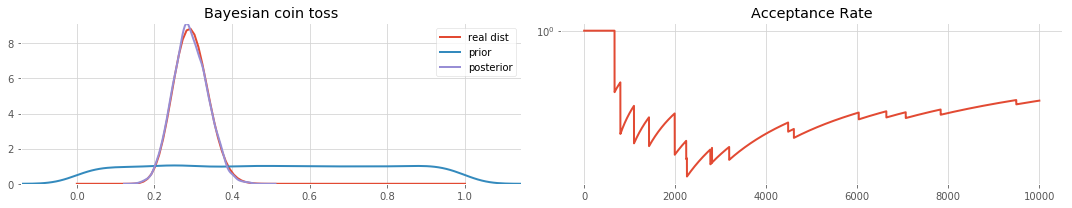

In [13]:
bayesian_coin_toss_mcmc()

>> 10 throws with p=0.2 : 4 heads and 6 tails


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 655.27it/s]


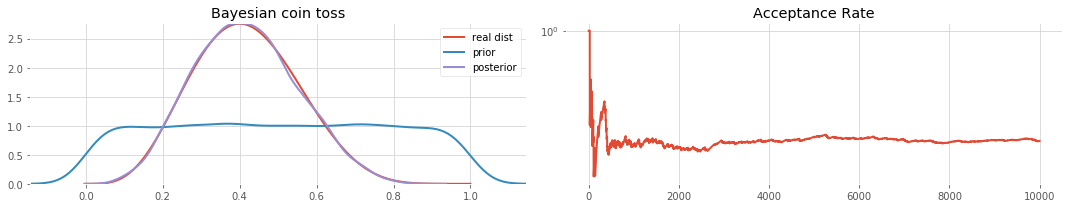

In [14]:
bayesian_coin_toss_mcmc(size = 10)

##### With a Normal prior being really sure that the coin is fair
With only 10 throws, we are still confident the coin is fair

>> 10 throws with p=0.2 : 2 heads and 8 tails


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1013.42it/s]


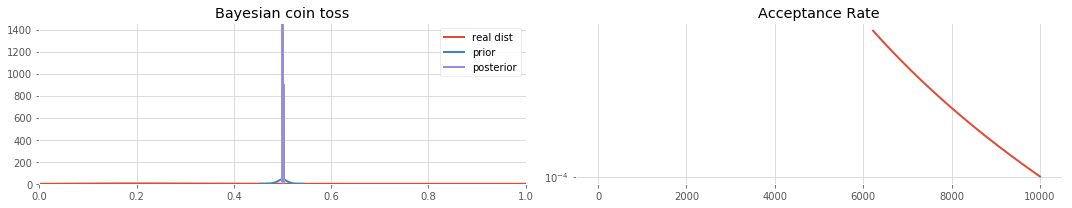

In [17]:
bayesian_coin_toss_mcmc(size = 10,prior = Normal(loc = 0.5,scale = 0.01))

With a thousand throws, we are starting to be a little less confident

>> 1000 throws with p=0.2 : 195 heads and 805 tails


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 623.09it/s]


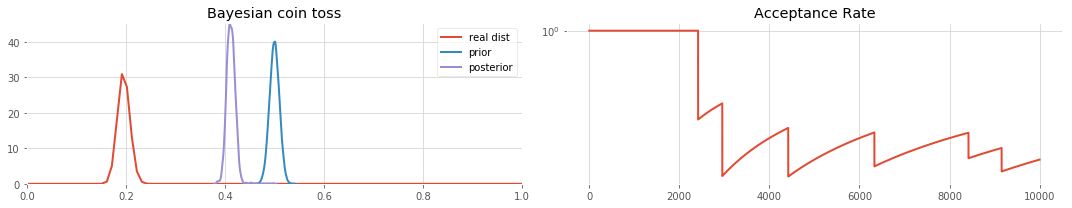

In [18]:
bayesian_coin_toss_mcmc(size = 1000,prior = Normal(loc = 0.5,scale = 0.01))

With thousands of throws, our a priori is disappearing

>> 10000 throws with p=0.2 : 1965 heads and 8035 tails


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 634.84it/s]


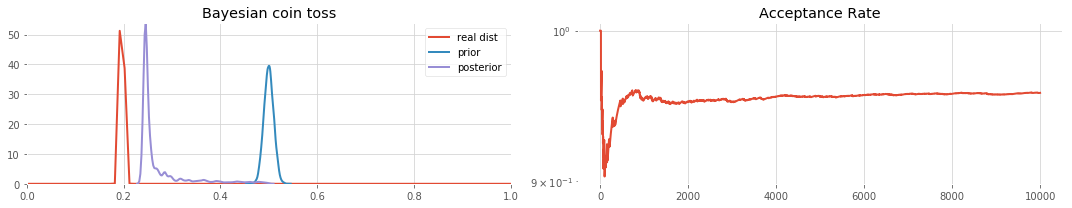

In [20]:
bayesian_coin_toss_mcmc(size = 10000,prior = Normal(loc = 0.5,scale = 0.01))

##### With a Normal distribution but few confidence in our a priori
We quickly forget our prior, and the posterior converges to the conjugate of the Uniform prior

>> 1000 throws with p=0.2 : 178 heads and 822 tails


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 739.82it/s]


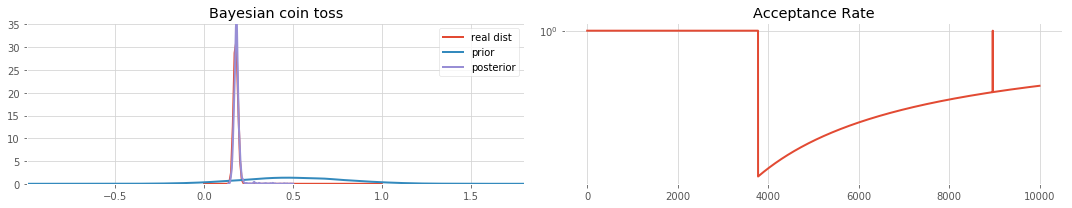

In [21]:
bayesian_coin_toss_mcmc(size = 1000,prior = Normal(loc = 0.5,scale = 0.3))

***
# Unsupervised clustering

In [4]:
import edward_utils as edu

## Fitting a normal distribution

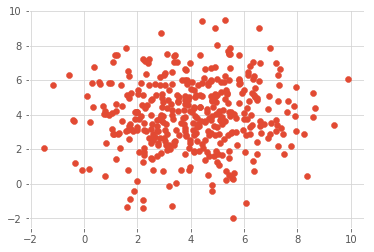

In [5]:
x1 = stats.norm.rvs(loc = 4,scale = 2,size = 400)
y1 = stats.norm.rvs(loc = 4,scale = 2,size = 400)

plt.scatter(x1,y1)
plt.show()

In [6]:
real_n = Normal(loc = 4.0,scale = 2.0)

### Fitting directly a normal distribution

In [7]:
n1 = Normal(loc = tf.zeros(1),scale = tf.ones(1)*2.0)
n1 = edu.Distribution(n1)

In [8]:
x = Normal(loc = n1.prior,scale = tf.ones([len(x1),]))
y = Normal(loc = n1.prior,scale = tf.ones([len(x1),]))

In [290]:
problem = edu.Problem([n1])

>> Initializing ... 

Exception ignored in: <bound method ScopedTFStatus.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFStatus object at 0x00000000393A4748>>
Traceback (most recent call last):
  File "C:\Users\talvesdacosta\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 36, in __del__
    c_api.TF_DeleteStatus(self.status)
AttributeError: 'ScopedTFStatus' object has no attribute 'status'


ok


100%|███████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 134.76it/s]


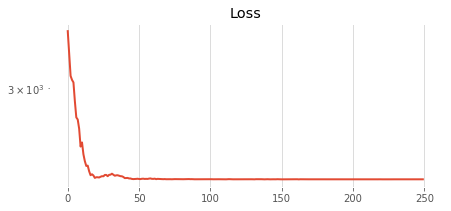

In [297]:
problem.run({x:x1, y:y1},n_samples = 50,n_iter = 250)

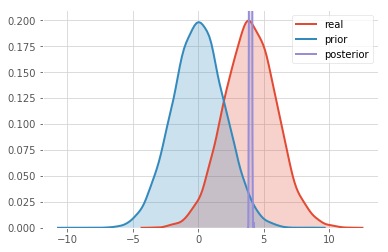

In [298]:
sns.distplot(real_n.sample(10000).eval(),bins = 20,label = "real",hist = False,kde_kws={"shade": True})
n1.plot()

### Adding uncertainty to the normal distribution parameters

In [9]:
mu1 = edu.Distribution(Uniform(low = 0.0,high = 12.0))
std1 = edu.Distribution(Uniform(low = 0.0,high = 12.0))

In [10]:
mu1.init_posterior(empirical=True,positive=True,n_samples=10000)
std1.init_posterior(empirical=True,positive=True,n_samples=10000)

In [11]:
n1 = Normal(loc = mu1.prior,scale = std1.prior)
qn1 = Normal(loc = mu1.posterior,scale = std1.posterior)

In [12]:
final_n = edu.Distribution(n1)
final_n.posterior = qn1

In [13]:
x = Normal(loc = n1,scale = tf.ones([len(x1),]))
y = Normal(loc = n1,scale = tf.ones([len(x1),]))

In [14]:
problem = edu.Problem([mu1,std1])

>> Initializing ... ok


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 525.40it/s]


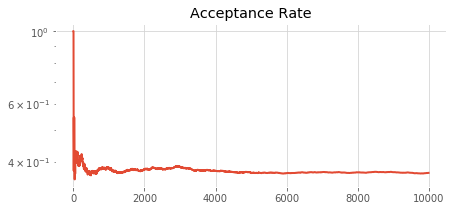

In [29]:
problem.run({x:x1,y:y1},step_size = 10e-3,method = "hmc")

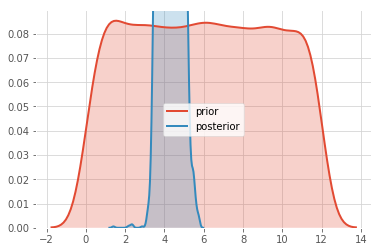

In [30]:
mu1.plot()

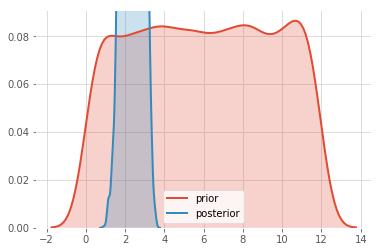

In [31]:
std1.plot()

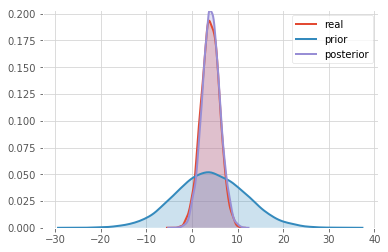

In [32]:
sns.distplot(real_n.sample(10000).eval(),bins = 20,label = "real",hist = False,kde_kws={"shade": True})
final_n.plot()

## Unsupervised clustering in 2D

### Creating the dataset

In [141]:
x1 = stats.norm.rvs(loc = 4,scale = 2,size = 400)
y1 = stats.norm.rvs(loc = 4,scale = 2,size = 400)
x2 = stats.norm.rvs(loc = 8,scale = 2,size = 400)
y2 = stats.norm.rvs(loc = 8,scale = 2,size = 400)

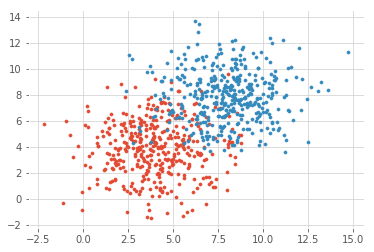

In [142]:
plt.scatter(x1,y1,label = "class 1",s = 10)
plt.scatter(x2,y2,label = "class 2",s = 10)
plt.show()

### Clustering

#### First model with fixed variances and simple distributions

##### Model

In [143]:
mu1 = Uniform(low = 0.0,high = 12.0)
mu2 = Uniform(low = 0.0,high = 12.0)

In [ ]:
n1 = Normal(loc = mu1,scale = 2.0,sample_shape = len(data))
n2 = Normal(loc = mu2,scale = 1.2,sample_shape = len(data))

In [144]:
n_samples = 10000

qmu1 = Empirical(params=tf.Variable(tf.zeros([n_samples,])))
qmu2 = Empirical(params=tf.Variable(tf.zeros([n_samples,])))

## Unsupervised clustering  of simple normal distributions 

### Creating the dataset

In [62]:
x1 = pd.Series(stats.norm.rvs(loc = 4,scale = 2,size = 1000)).round(1).value_counts().sort_index()
x2 = pd.Series(stats.norm.rvs(loc = 10,scale = 1.2,size = 1000)).round(1).value_counts().sort_index()

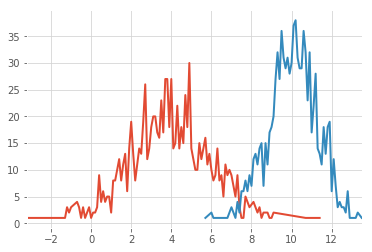

In [63]:
x1.plot()
x2.plot()
plt.show()

In [68]:
data = pd.DataFrame(x1,columns = ["class 1"])
data = data.join(pd.DataFrame(x2,columns = ["class 2"]),how = "outer").fillna(0)
data = data[data.index >= 0]
data["data"] = np.max([data["class 1"],data["class 2"]],axis = 0)

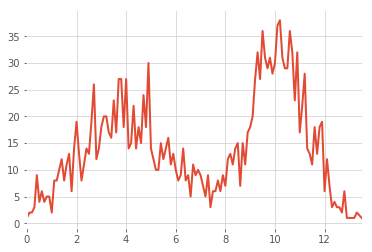

In [70]:
data["data"].plot()
plt.show()

### Clustering

##### Creating the model

In [72]:
std1 = Uniform(low = 0.0,high = 15.0)
std2 = Uniform(low = 0.0,high = 15.0)

In [74]:
mu1 = Uniform(low = 0.0,high = 7.0)
mu2 = Uniform(low = 7.0,high = 13.0)

In [111]:
n1 = Normal(loc = mu1,scale = 2.0,sample_shape = len(data))
n2 = Normal(loc = mu2,scale = 1.2,sample_shape = len(data))

In [122]:
n_ = tf.maximum(n1,n2,"data")

In [123]:
n_

<tf.Tensor 'data_3:0' shape=(135,) dtype=float32>

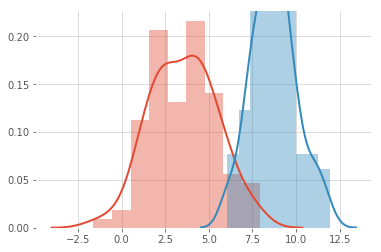

In [114]:
sns.distplot(n1.sample(100).eval(session = ed.get_session()))
sns.distplot(n2.sample(100).eval(session = ed.get_session()))
plt.show()

In [116]:
n_samples = 10000

qmu1 = Empirical(params=tf.Variable(tf.zeros([n_samples,])))
qmu2 = Empirical(params=tf.Variable(tf.zeros([n_samples,])))
# qstd1 = Empirical(params=tf.nn.softplus(tf.Variable(tf.zeros([n_samples]))))
# qstd2 = Empirical(params=tf.nn.softplus(tf.Variable(tf.zeros([n_samples]))))

##### Inference

In [117]:
inference = ed.HMC(latent_vars = {mu1 : qmu1,
                                  mu2 : qmu2,
#                                   std1 : qstd1,
#                                   std2 : qstd2,
                                 },
                   
                   data={n_:data["data"].as_matrix()})

In [118]:
inference.initialize(step_size = 1/len(data))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 912.69it/s]
C:\Users\talvesdacosta\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


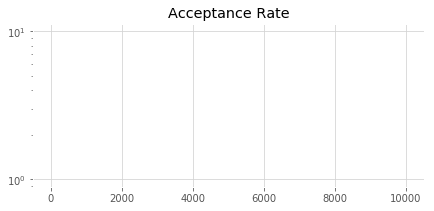

In [119]:
# RUNNING THE INFERENCE
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
acceptance_rates = []
for _ in tqdm(range(inference.n_iter)):
    info_dict = inference.update()
    acceptance_rates.append(info_dict['accept_rate'])
plt.figure(figsize = (7,3))
plt.title("Acceptance Rate")
plt.semilogy(acceptance_rates)
plt.show()

C:\Users\talvesdacosta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\talvesdacosta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


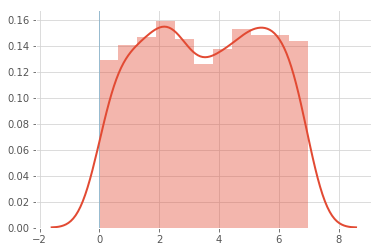

In [109]:
sns.distplot(mu1.sample(1000).eval(),label = "prior")
sns.distplot(qmu1.sample(1000).eval(),label = "posterior")
plt.show()

In [ ]:

    
    # PLOTTING THE RESULTS
    sp = plt.subplot(1, 2, 1)
    real_dist = stats.beta.pdf(np.linspace(0,1,100),1+n_heads,1+n_tails)
    plt.plot(np.linspace(0,1,100),real_dist,label = "real dist")
    sns.distplot(p.sample(10000).eval(),bins = 20,label = "prior",hist = False)
    sns.distplot(qp.sample(10000).eval(),bins = 20,label = "posterior",hist = False)
    plt.legend()
    plt.title("Bayesian coin toss")
    sp.set_xlim([0,1])
    
    plt.autoscale(tight=True)
    
    plt.tight_layout()
    plt.show()

***
# The SMS behavior problem

## Creating the dataset

##### Switching point

In [6]:
tau = np.random.randint(0,80)
tau = 48
tau

48

##### Draw $\lambda_1$ and $\lambda_2$ from exponential distribution

In [7]:
alpha = 1/20.

In [8]:
lambda1,lambda2 = np.random.exponential(scale = 1/alpha,size = 2)
lambda1,lambda2 = 41.3107591263,17.5161468002
print(lambda1,lambda2)

41.3107591263 17.5161468002


##### Sample from Poisson distribution the number of texts sent

In [9]:
data1 = stats.poisson.rvs(mu = lambda1,size = tau)
data2 = stats.poisson.rvs(mu = lambda2,size = 80 - tau)
data1

array([47, 28, 20, 43, 41, 51, 46, 40, 52, 38, 39, 30, 45, 41, 35, 44, 37,
       47, 41, 40, 40, 47, 27, 46, 41, 25, 43, 43, 33, 38, 31, 50, 31, 51,
       39, 38, 43, 44, 42, 37, 44, 30, 40, 38, 37, 33, 36, 48])

In [10]:
data = np.hstack([data1,data2])

##### Plot the dataset

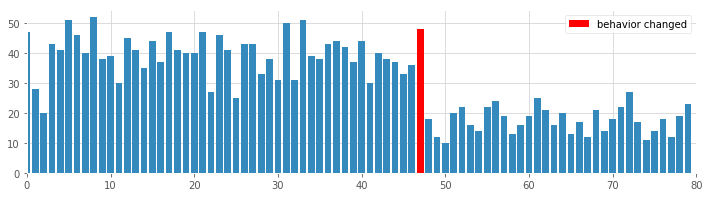

In [11]:
plt.figure(figsize=(12,3))
plt.bar(np.arange(80),data,color = colors[0])
plt.bar(tau-1,data[tau-1],color = "r",label = "behavior changed")
plt.legend()
plt.xlim(0,80)
plt.show()

## Solving the problem

### Solving the problem with Edward

In [20]:
sess = tf.Session()

In [21]:
alpha_observed = 1.0 / data.mean()
alpha_observed

0.032454361054766734

In [22]:
alpha_observed = tf.Variable(alpha_observed, name="alpha", dtype=tf.float32)
alpha_observed

<tf.Variable 'alpha_1:0' shape=() dtype=float32_ref>

In [23]:
from edward import models

In [24]:
lambda1 = Exponential(alpha_observed)
lambda2 = Exponential(alpha_observed)
tau = Uniform(low = 0.0,high = 80.0)
idx = np.arange(80)

In [26]:
lambda_ = tf.where(tau>=idx,
                   tf.ones(shape=[80,],dtype=tf.float32)*lambda1,
                   tf.ones(shape=[80,],dtype=tf.float32)*lambda2)

In [27]:
z = Poisson(lambda_,value=tf.Variable(tf.ones(80)))

In [30]:
T = 10000  # number of posterior samples
qlambda1 =  Empirical(params=tf.Variable(tf.ones([T,])))
qlambda2 =  Empirical(params=tf.Variable(tf.ones([T,])))

In [31]:
qtau = Empirical(params=tf.Variable(tf.ones([T,])))

In [39]:
inference = ed.HMC({lambda1:qlambda1,lambda2:qlambda2,tau:qtau},data={z:data})

In [40]:
inference.initialize(step_size = 1/80)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 727.97it/s]


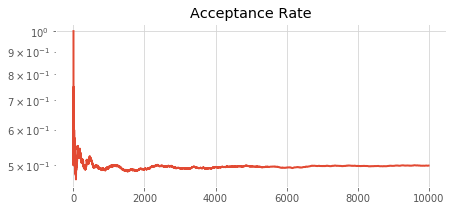

In [41]:
# RUNNING THE INFERENCE
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
acceptance_rates = []
for _ in tqdm(range(inference.n_iter)):
    info_dict = inference.update()
    acceptance_rates.append(info_dict['accept_rate'])
plt.figure(figsize = (7,3))
plt.title("Acceptance Rate")
plt.semilogy(acceptance_rates)
plt.show()

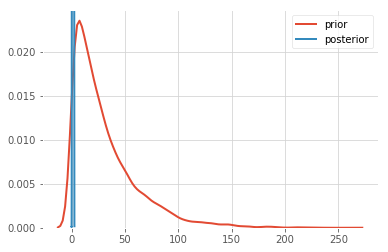

In [42]:
sns.distplot(lambda1.sample(10000).eval(),kde = True,hist = False,label = "prior")
sns.distplot(qlambda1.sample(10000).eval(),kde = True,hist = False,label = "posterior")
plt.legend()
plt.show()

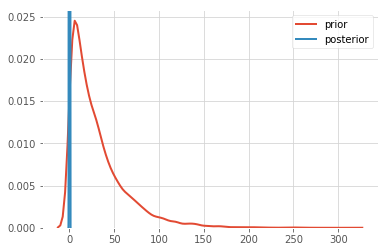

In [43]:
sns.distplot(lambda2.sample(10000).eval(),kde = True,hist = False,label = "prior")
sns.distplot(qlambda2.sample(10000).eval(),kde = True,hist = False,label = "posterior")
plt.legend()
plt.show()

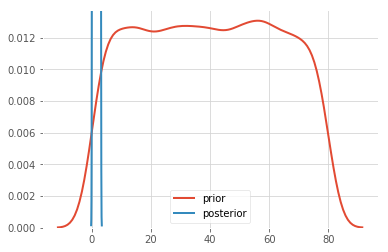

In [44]:
sns.distplot(tau.sample(10000).eval(),kde = True,hist = False,label = "prior")
sns.distplot(qtau.sample(10000).eval(),kde = True,hist = False,label = "posterior")
plt.legend()
plt.show()

### Solving the problem with Pyro

## With other artificial datasets